# Introduction
# Datasets
- https://www.kaggle.com/datasets/hkayan/anomliot
- https://www.kaggle.com/datasets/ziya07/smart-manufacturing-iot-cloud-monitoring-dataset


# Edge Telemetry Anomaly Detection with LightGBM → ONNX

**Steps:**
1. Load SMART telemetry
2. Feature engineering (rolling window stats)
3. Train compact LightGBM autoencoder
4. Evaluate on holdout set
5. Export to ONNX & quantize
6. Benchmark size & latency
7. Demonstrate streaming inference

# Installation

In [ ]:
!pip3 install lightgbm onnxmltools onnxruntime numpy pandas sklearn matplotlib

# Load Libraries

In [13]:
import warnings
warnings.filterwarnings("ignore")

import time
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb

from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import onnxmltools
from onnxmltools.convert import convert_lightgbm
import onnxruntime as ort



# Code

In [8]:
# 1. Load dataset (example: SMART CSV)
data = pd.read_csv('dataset/smart_manufacturing_data.csv', parse_dates=['timestamp'])
data = data.sort_values(['machine_id','timestamp']).reset_index(drop=True)
data.head()

,timestamp,machine_id,temperature,vibration,humidity,pressure,energy_consumption,machine_status,anomaly_flag,predicted_remaining_life,failure_type,downtime_risk,maintenance_required
0,2025-01-01 01:37:00,1,62.59,48.08,60.13,1.62,4.16,1,0,363,Normal,0.0,0
1,2025-01-01 01:42:00,1,70.88,68.67,50.57,1.05,2.36,1,0,111,Normal,0.0,0
2,2025-01-01 02:13:00,1,62.34,72.68,60.47,2.24,4.95,1,0,192,Normal,0.0,0
3,2025-01-01 02:19:00,1,88.03,53.36,50.79,3.08,2.25,1,0,301,Normal,0.0,0
4,2025-01-01 03:05:00,1,79.39,49.44,56.99,2.54,2.76,1,0,127,Normal,0.0,0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   timestamp                 100000 non-null  datetime64[ns]
 1   machine_id                100000 non-null  int64         
 2   temperature               100000 non-null  float64       
 3   vibration                 100000 non-null  float64       
 4   humidity                  100000 non-null  float64       
 5   pressure                  100000 non-null  float64       
 6   energy_consumption        100000 non-null  float64       
 7   machine_status            100000 non-null  int64         
 8   anomaly_flag              100000 non-null  int64         
 9   predicted_remaining_life  100000 non-null  int64         
 10  failure_type              100000 non-null  object        
 11  downtime_risk             100000 non-null  float64       
 12  mai

In [21]:
print('Number of machines:', len(set(data['machine_id'].tolist())))
Counter(data["anomaly_flag"].tolist())

Number of machines: 50


Counter({0: 91084, 1: 8916})

We plot the distribution of features and the anomaly flag

We noticed that:
- Temperature and vibrations have a normal distrution
- Humidity, pressure, and energy consumption have a uniform distribution

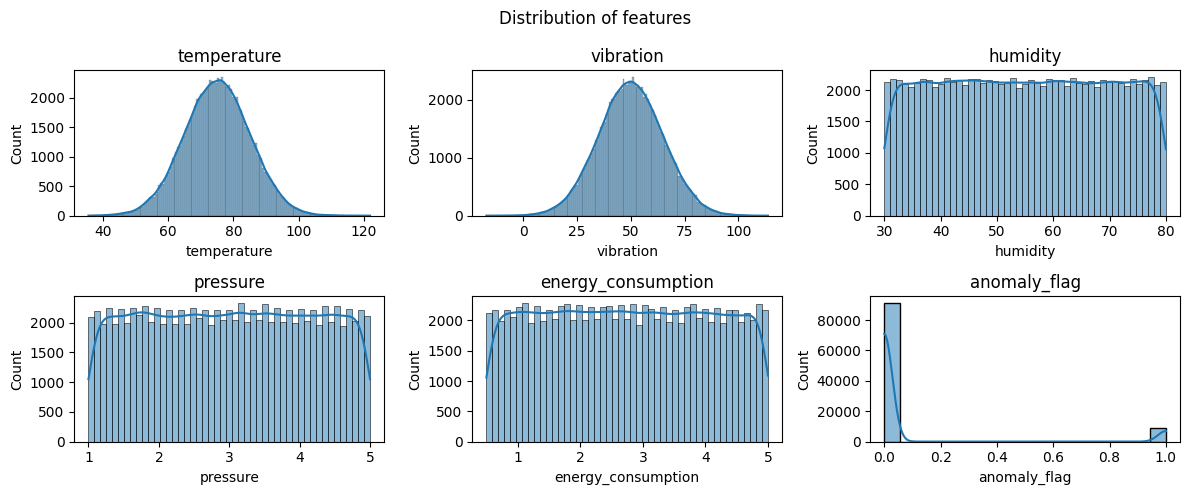

In [32]:
features = ["temperature", "vibration", "humidity", "pressure", "energy_consumption", "anomaly_flag"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    sns.histplot(data[feat], kde=True, ax=ax)
    ax.set_title(f"{feat}")
    
plt.suptitle('Distribution of features')
plt.tight_layout()

Similarly, we plot the boxplot of the features
- As we can see in the temperature and vibration boxplot, they are the features that contains a lot of outliers, as compared to the others (humidity, pressure, and energy consumption)

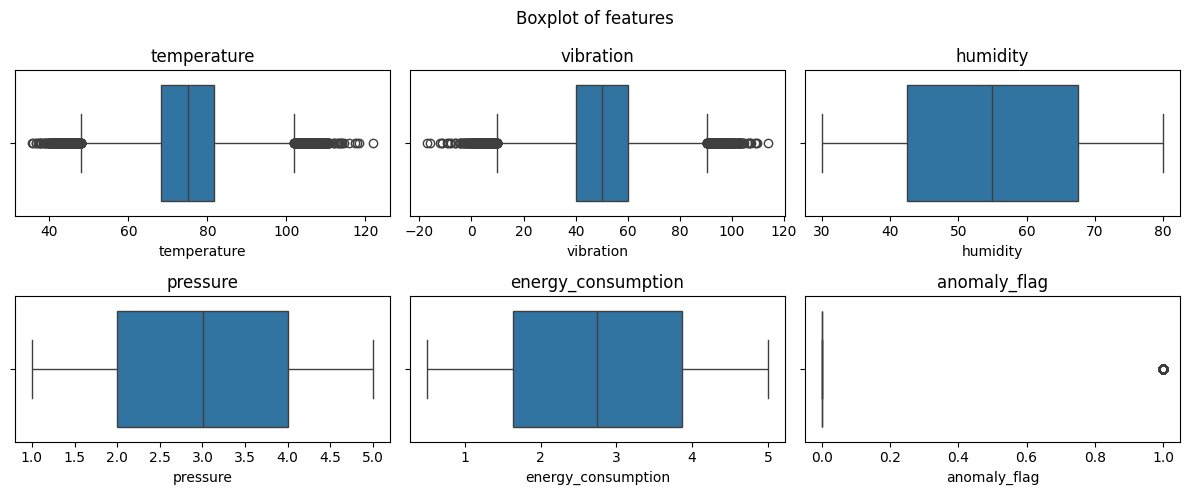

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5))
axes = axes.flatten()

for ax, feat in zip(axes, features):
    sns.boxplot(x=data[feat], ax=ax)
    ax.set_title(f"{feat}")
    
plt.suptitle('Boxplot of features')
plt.tight_layout()

Next, we randomly select a machine and plot the time-series of the anomaly. From this sample, we identify the following:
- Extremely high (overheating) and low (machine not started) temperature indicates an anomaly
- Extremely high (motor moving too fast) and low (motor barely moving) vibration indicates an anomaly
- Meanwhile, for the other features, it is not as obvious

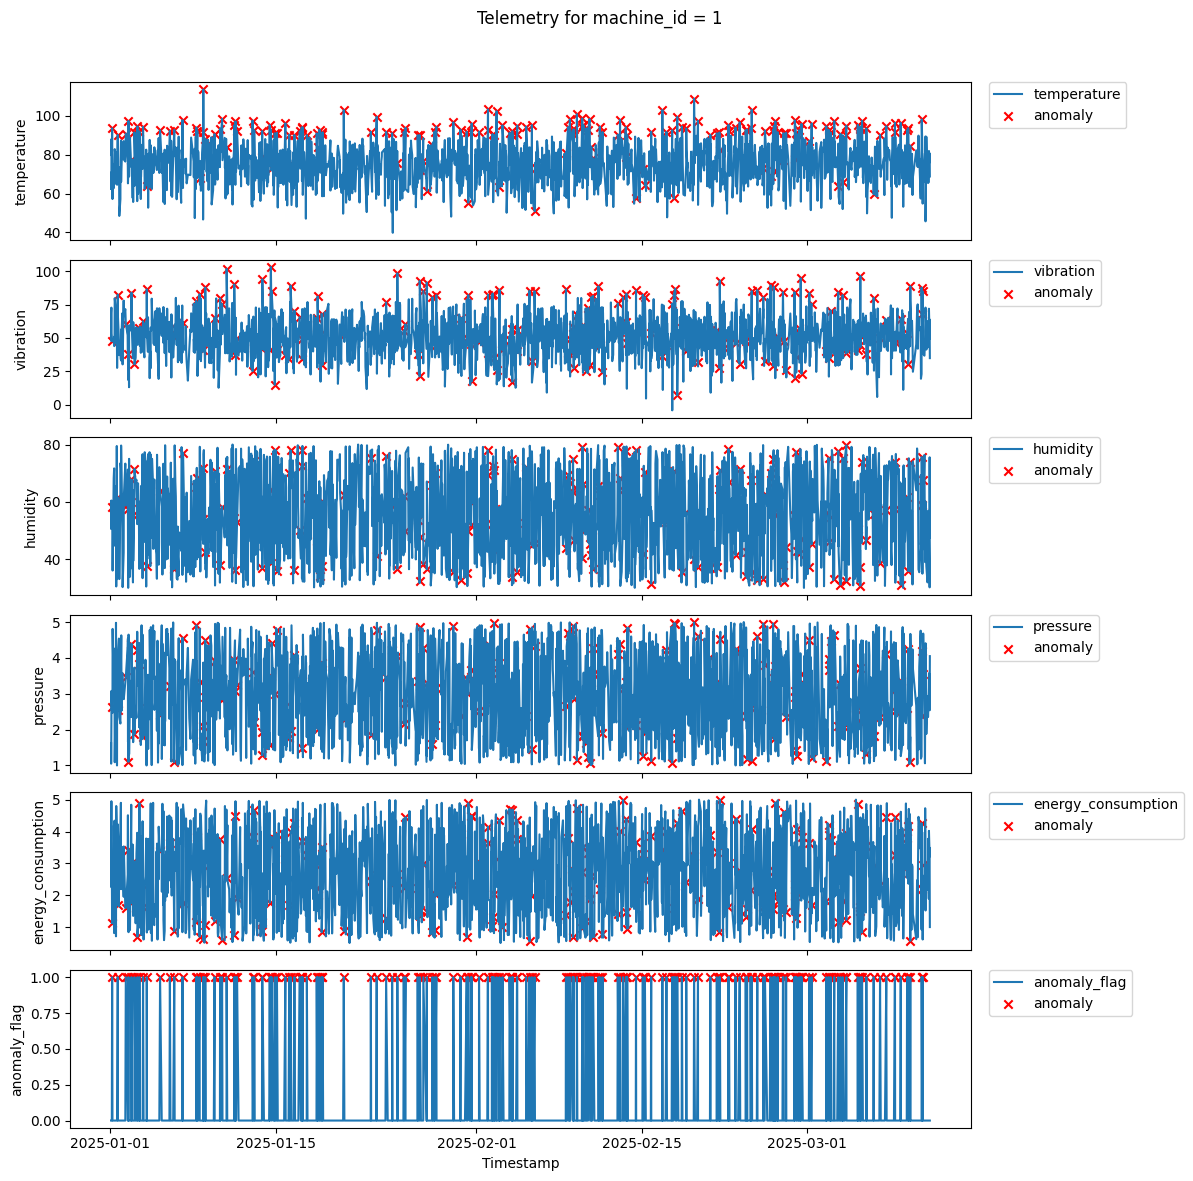

In [34]:
# Choose a specific machine to visualize:
mid = data['machine_id'].unique()[0]
sub = data[data['machine_id'] == mid].sort_values('timestamp')

fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(12, 2*len(features)), sharex=True)
for ax, feat in zip(axes, features):
    ax.plot(sub['timestamp'], sub[feat], label=feat)
    ax.scatter(sub['timestamp'][sub['anomaly_flag']==1], 
               sub[feat][sub['anomaly_flag']==1],
               color='red', marker='x', label='anomaly')
    # ax.legend(loc='upper right')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    ax.set_ylabel(feat)
axes[-1].set_xlabel('Timestamp')
plt.suptitle(f"Telemetry for machine_id = {mid}")
plt.tight_layout(rect=[0, 0, 1, 0.96])


Next, we can look at the correlation and interaction heatmap. From here, we can see that temperature and vibration is correlated to anomaly more than the other features, indicating that they will be the most significant features to indicates an anomaly.

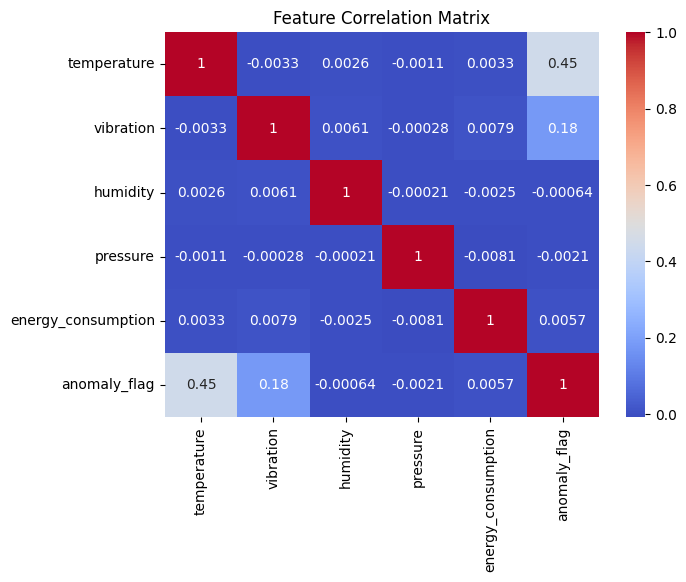

In [35]:
plt.figure(figsize=(7,5))
sns.heatmap(data[features].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [38]:
# sns.pairplot(data[["temperature","vibration","energy_consumption","humidity", 'anomaly_flag']])
# plt.show()

Failure type distribution:
 failure_type
Normal              91899
Vibration Issue      3129
Overheating          1989
Pressure Drop        1969
Electrical Fault     1014
Name: count, dtype: int64


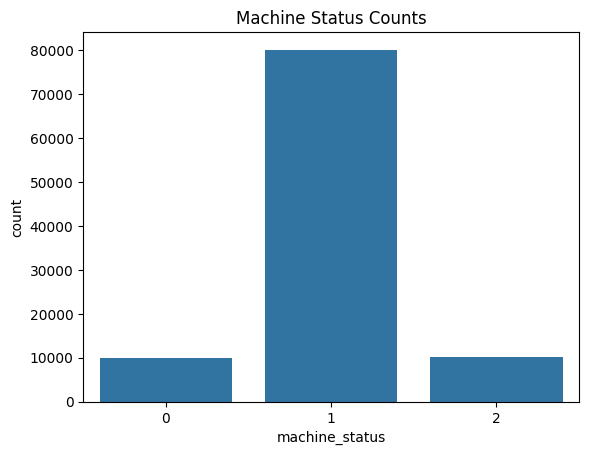

In [44]:
# 8. Categorical Insights
counts = data["failure_type"].value_counts(dropna=False)
print("Failure type distribution:\n", counts)

sns.countplot(data=data, x="machine_status")
plt.title("Machine Status Counts")
plt.show()


In [ ]:
# 2. Feature engineering: 7-day rolling stats
def fe(feat):
    return {
        f'{feat}_mean': data.groupby('drive_id')[feat].rolling(7).mean().reset_index(0,drop=True),
        f'{feat}_std':  data.groupby('drive_id')[feat].rolling(7).std().reset_index(0,drop=True),
        f'{feat}_diff': data.groupby('drive_id')[feat].diff()
    }

rolls = {}
for feat in ['temp','realloc_sectors','read_errors']:
    rolls.update(fe(feat))
    
df = data.join(pd.DataFrame(rolls))
df = df.dropna()  # drop first 7 days
X = df[[c for c in df if c not in ['drive_id','date','failure']]].values
y = df['failure'].values  # 1 if failure within next week


In [ ]:
# 3. Scale, split, and train LightGBM binary classifier
scaler = MinMaxScaler()
X_s = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X_s,y,test_size=0.2,random_state=42)

model = lgb.LGBMClassifier(n_estimators=50, max_depth=6)
model.fit(X_train, y_train)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
y_pred = model.predict(X_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print(f'Prec={prec:.2f}, Rec={rec:.2f}, F1={f1:.2f}, AUC={roc_auc_score(y_test,model.predict_proba(X_test)[:,1]):.2f}')


In [ ]:
# 4. Convert and quantize to ONNX
initial_types = [('input', onnxmltools.convert.common.data_types.FloatTensorType([None,X_train.shape[1]]))]
onnx_model = convert_lightgbm(model.booster_, initial_types=initial_types)
with open('model_fp32.onnx','wb') as f: f.write(onnx_model.SerializeToString())

from onnxmltools import quantization
q_model = quantization.quantize_dynamic('model_fp32.onnx','model_int8.onnx')


In [ ]:
# 5. Benchmark model size and inference latency
def bench(onnx_path):
    sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    Xp = X_test[:1000].astype(np.float32)
    start = time.time()
    for _ in range(10):
        _ = sess.run(None, {'input':Xp})
    return os.path.getsize(onnx_path), (time.time()-start)/10

print('FP32:', bench('model_fp32.onnx'))
print('INT8:', bench('model_int8.onnx'))


In [ ]:
# 6. Streaming inference simulation
sess = ort.InferenceSession('model_int8.onnx', providers=['CPUExecutionProvider'])
threshold = 0.8
for i in range(1000,1050):  # sample stream
    x = X_test[i].reshape(1,-1).astype(np.float32)
    prob = sess.run(None, {'input': x})[1][0,1]  # assuming classifier outputs class probabilities
    if prob > threshold:
        print(f'Anomaly at index {i}, score={prob:.2f}')


In [ ]:
# 7. Plotting ROC curve
from sklearn.metrics import roc_curve, auc
y_score = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.2f}")
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.title('ROC')
